In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from model.cnn import CNN
from model.encoder import Encoder
from model.decoder import Decoder
from model.endtoend import HME2LaTeX
from model.language import *
from data_processing.loadData import HMEDataset
import pandas as pd

In [2]:
EXISTING_MODEL_PATH = './trainedmodelsymbols.tar'

## Testing the model on already seen (training) data

In [3]:
labels = '..\data\CROHME2016_data\data_png\data_png_trainingSymbols\iso_GT.txt'
images = '..\\data\\CROHME2016_data\\data_png\\data_png_trainingSymbols'
dataset = HMEDataset(labels, images, problem_type='symbols')
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
latex = Lang('latex')
for labels in dataset.img_labels.iloc[:,1]:
    latex.addSentence(labels)

In [5]:
train_dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

In [6]:
words = torch.nn.utils.rnn.pad_sequence([tensorFromSentence(latex,dataset.img_labels.iloc[i,1]) for i in range(len(dataset.img_labels))], padding_value=-1)

In [7]:
cnn = CNN(device).to(device)
encoder = Encoder(512, 256, 32*31, BATCH_SIZE).to(device)
decoder = Decoder(1,512,latex.n_words,32*31, BATCH_SIZE,device).to(device)
model = HME2LaTeX(cnn,encoder,decoder,words.shape[0],BATCH_SIZE, latex.n_words, 1, 0, words.shape[0],device)
checkpoint = torch.load(EXISTING_MODEL_PATH, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [8]:
iterator = iter(train_dataloader)

run the cell below to get the accuracy of the model on a sample of size 32

In [9]:
img,labels,indices = next(iterator)
pred = model(img.float().to(device), None)
target = words[:,indices,:].to(device)
torch.count_nonzero(decoder.softmax_out(pred[:,:,:]).topk(1)[1].view(3,32).T[:,0] == target.view(3,32).T[:,1]) / (BATCH_SIZE) * 100

tensor(93.7500)

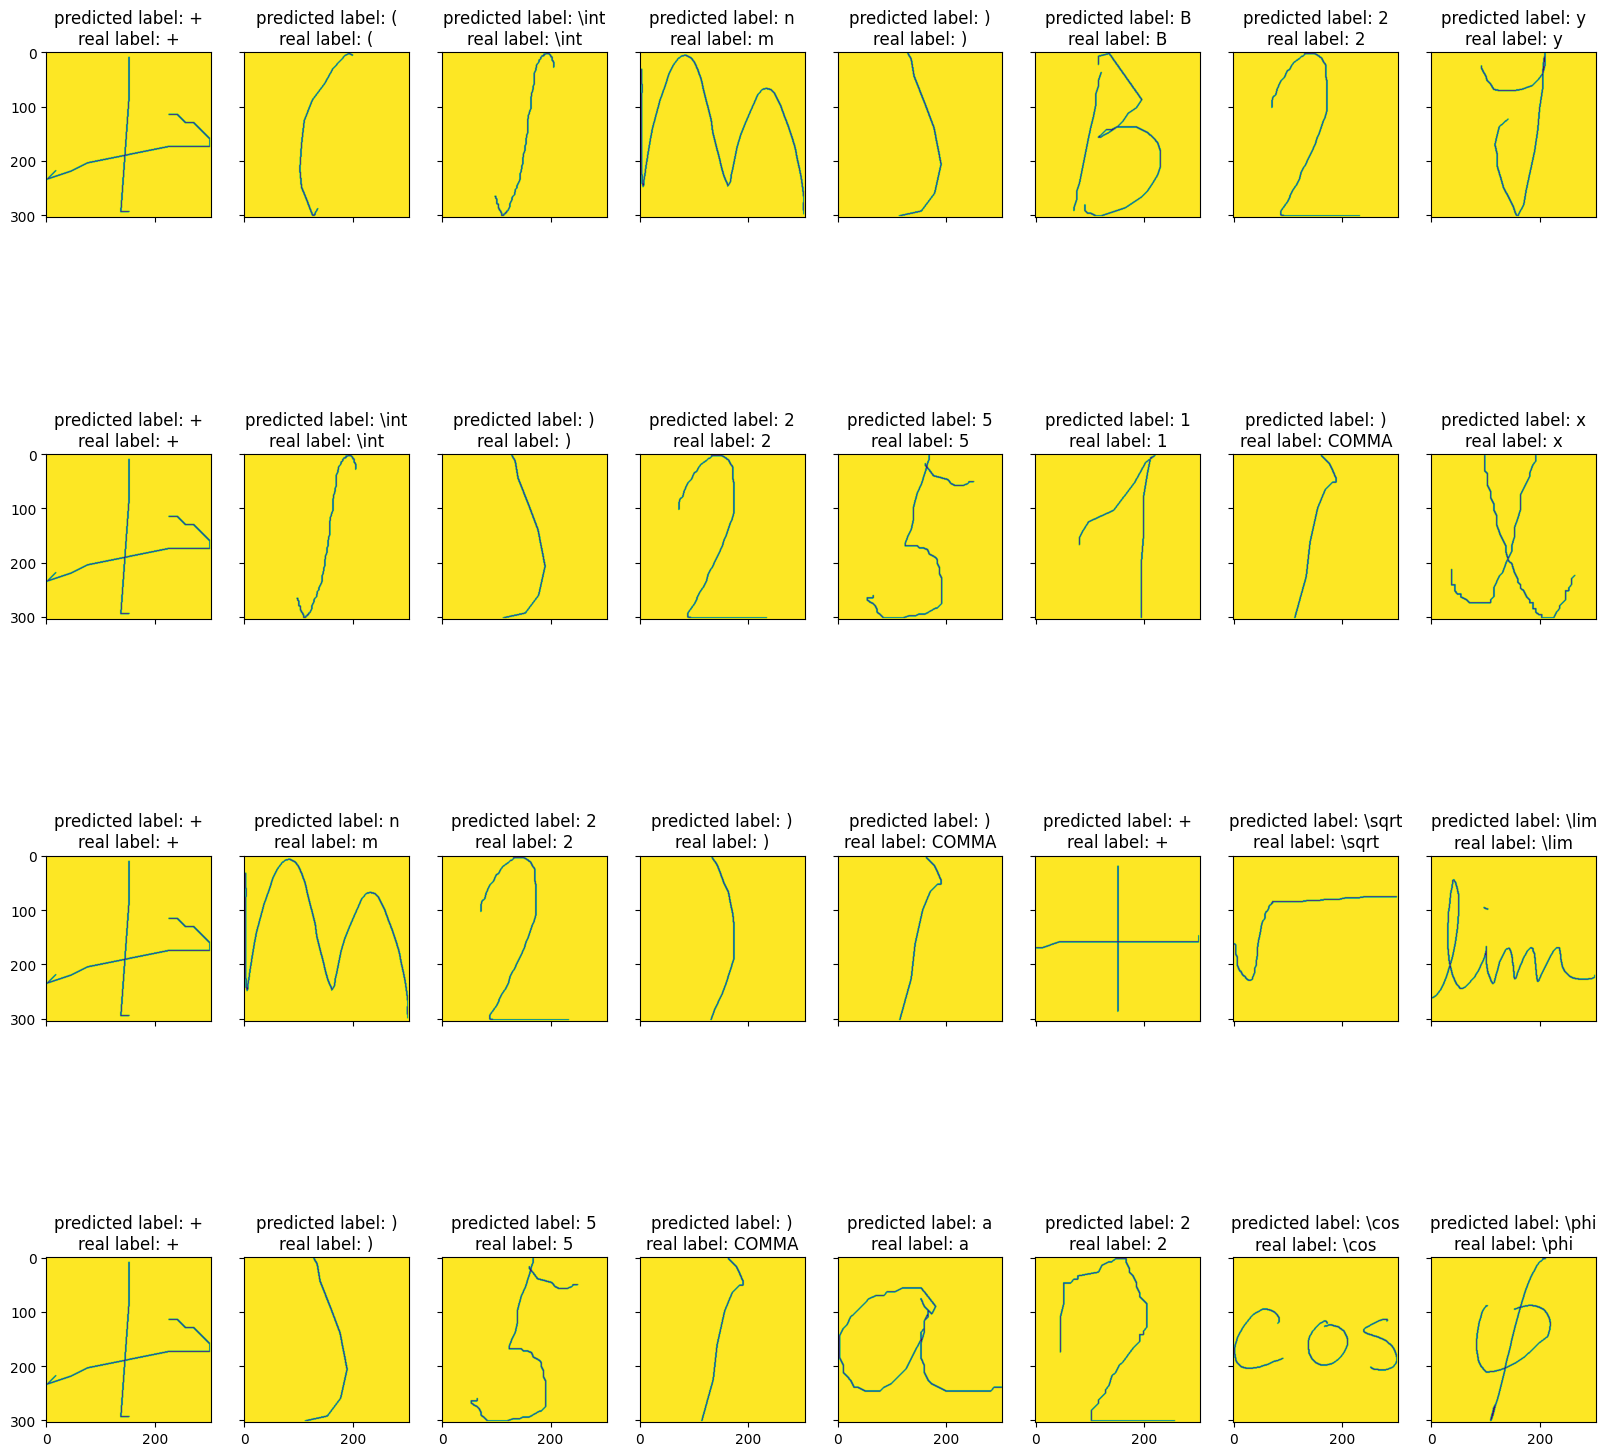

In [10]:
predicted_label = [latex.index2word[decoder.softmax_out(pred[:,:,:]).topk(1)[1].view(3,32).T[i,0].item()] for i in range(BATCH_SIZE)]
numpy_images = img.cpu().numpy()
fig,axs = plt.subplots(4,8, figsize=(20,20))
for i in range(4):
    for j in range(8):
        axs[i,j].imshow(numpy_images[(i+1)*j].reshape((304,304)))
        axs[i,j].set_title(f'predicted label: {predicted_label[(i+1)*j]}\nreal label: {labels[(i+1)*j]}')
        axs[i,j].label_outer()

## Distribution of symbols in the training set

<AxesSubplot: >

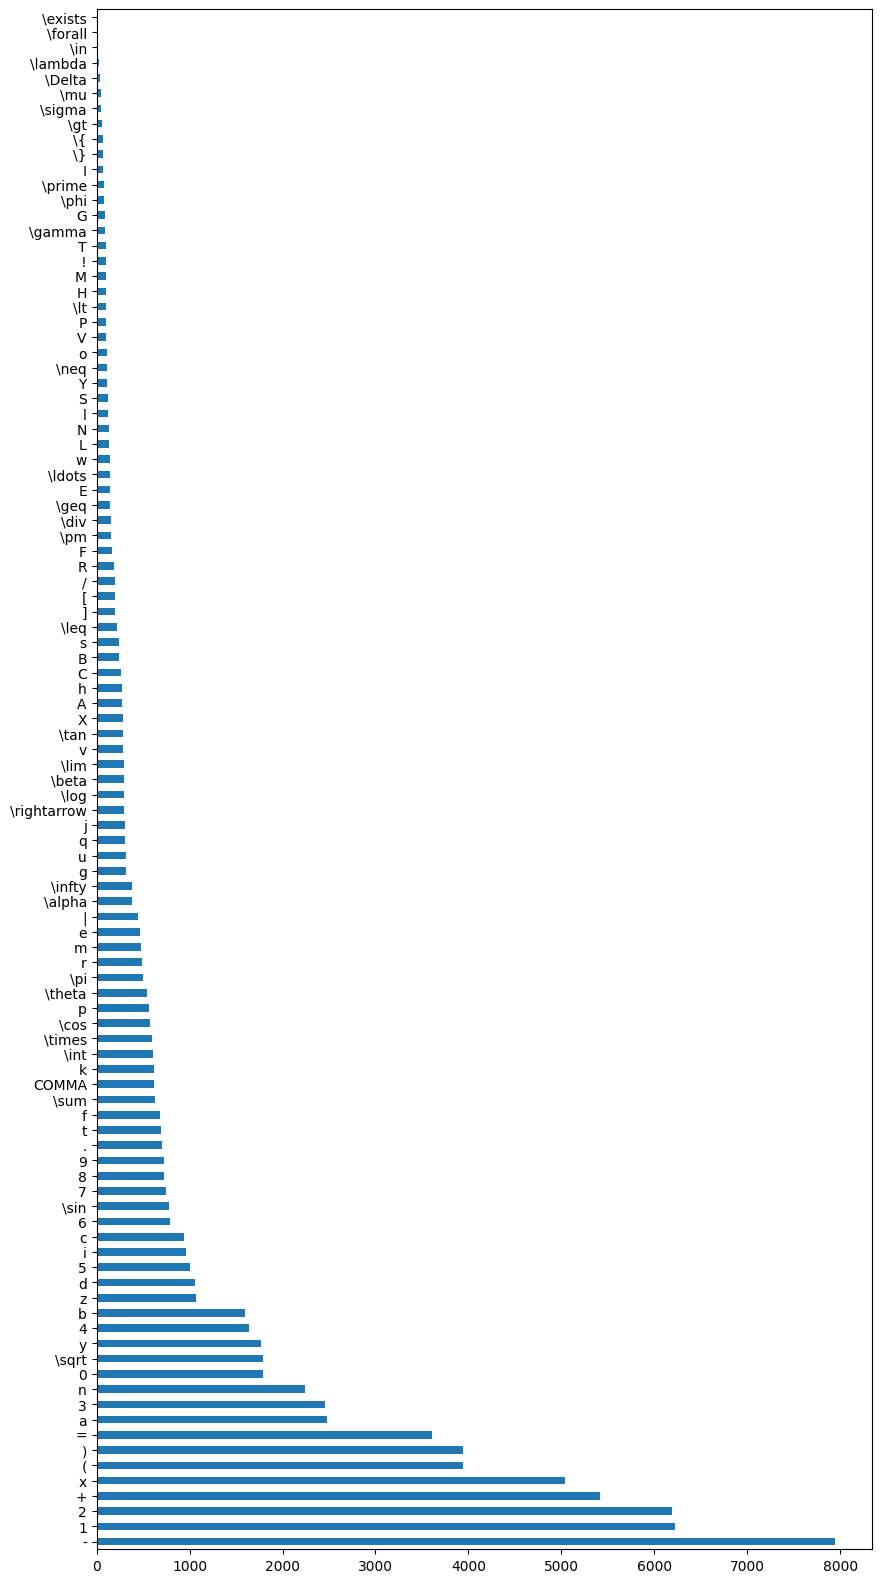

In [62]:
dataset.img_labels.iloc[:,1].value_counts().plot(kind='barh', figsize=(10,20))

run the cells below to compute the accuracy on all the dataset (will take a lot of time)

In [ ]:
correct = torch.zeros(1).to(device)
i=0

In [ ]:
train_dataloader_in_order = DataLoader(dataset, BATCH_SIZE, shuffle=True, drop_last=True)
for i,(img,labels,indices) in enumerate(train_dataloader_in_order):
    pred = model(img.float().to(device), None)
    target = words[:,indices,:].to(device)
    correct += torch.count_nonzero(decoder.softmax_out(pred[:,:,:]).topk(1)[1].view(3,32).T[:,0] == target.view(3,32).T[:,1])
print(correct)

In [ ]:
correct / (i*BATCH_SIZE), i*BATCH_SIZE

## Testing the model on never seen data 

In [11]:
test_labels = '..\data\CROHME2016_data\data_png\data_png_testSymbols\\testSymbols_2016_iso_GT.txt'
test_images = '..\data\CROHME2016_data\data_png\data_png_testSymbols\\'
test_dataset = HMEDataset(test_labels, test_images, problem_type='symbols')

In [12]:
for label in test_dataset.img_labels.iloc[:,1]:
    latex.addSentence(label.strip())

In [13]:
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

In [14]:
test_words = torch.nn.utils.rnn.pad_sequence([tensorFromSentence(latex,test_dataset.img_labels.iloc[i,1].strip()) for i in range(len(test_dataset.img_labels))], padding_value=-1)

In [15]:
iterator = iter(test_dataloader)

run the cell below to get the accuracy on a sample of the test data

In [18]:
img,labels,indices = next(iterator)
right_indices = [i for i,_ in enumerate(indices) if test_words[1,i,:] != latex.word2index['junk']]
pred = model(img.float().to(device), None)
target = test_words[:,indices,:].to(device)
torch.count_nonzero(decoder.softmax_out(pred[:,right_indices,:]).topk(1)[1].view(3,len(right_indices)).T[:,0] == target[:,right_indices,:].view(3,len(right_indices)).T[:,1]) / (len(right_indices)) * 100

tensor(55.5556)

In [67]:
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)
correct = torch.zeros(1).to(device)
i = 0

run the cell below to get the testing accuracy on all the testing set

In [ ]:
for i,(img,labels,indices) in enumerate(test_dataloader):
    right_indices = [j for j,_ in enumerate(indices) if test_words[1,j,:] != latex.word2index['junk']]
    pred = model(img.float().to(device), None)
    target = test_words[:,indices,:].to(device)
    correct += torch.count_nonzero(decoder.softmax_out(pred[:,right_indices,:]).topk(1)[1].view(3,len(right_indices)).T[:,0] == target[:,right_indices,:].view(3,len(right_indices)).T[:,1])

In [85]:
correct / (test_dataset.img_labels.loc[test_dataset.img_labels.iloc[:,1] != ' junk'].shape[0]) * 100

tensor([15.1612])